In [1]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linprog
from scipy.stats import rankdata, ttest_ind, mannwhitneyu
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

# 设置绘图风格
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 10
sns.set_theme(style='whitegrid')

print('✓ 库加载完成')

✓ 库加载完成


## 1. 数据加载与预处理

In [3]:
# 加载处理后的数据和问题1的批量结果
DATA_PATH = '/Users/Zhuanz1/Desktop/mcm/MCM_Problem_C_Processed.csv'
BATCH_RESULTS_PATH = '/Users/Zhuanz1/Desktop/mcm/c/问题1_完整分析/问题1_批量结果_完整.csv'

df = pd.read_csv(DATA_PATH)
batch_results = pd.read_csv(BATCH_RESULTS_PATH)

print(f'原始数据规模: {df.shape[0]} 行 × {df.shape[1]} 列')
print(f'赛季范围: {df["season"].min()} - {df["season"].max()}')
print(f'\n问题1批量结果: {len(batch_results)} 个案例')
print(f'批量结果列名: {batch_results.columns.tolist()}')

原始数据规模: 421 行 × 33 列
赛季范围: 1 - 34

问题1批量结果: 228 个案例
批量结果列名: ['season', 'week', 'n_participants', 'eliminated_name', 'eliminated_fan_vote', 'eliminated_fan_ci_low', 'eliminated_fan_ci_high', 'eliminated_fan_std', 'eliminated_judge_score', 'judge_elim_rank', 'fan_elim_rank', 'rank_consistency', 'certainty', 'judge_mean', 'judge_std', 'size_group']


In [4]:
# 定义规则映射并添加到批量结果
def get_rule_type(season):
    """根据赛季返回合并规则类型
    S1-2 & S28-34: Rank (排名法)
    S3-27: Percentage (百分比法)
    """
    if season in [1, 2] or season >= 28:
        return 'rank'
    else:
        return 'percentage'

# 为原始数据添加规则类型
df['actual_rule'] = df['season'].apply(get_rule_type)

# 为批量结果添加规则类型（如果不存在）
if 'actual_rule' not in batch_results.columns:
    batch_results['actual_rule'] = batch_results['season'].apply(get_rule_type)

print('规则分布（原始数据）:')
print(df.groupby('actual_rule')['season'].agg(['count', 'nunique']))
print('\n规则分布（批量结果）:')
print(batch_results.groupby('actual_rule').size())

规则分布（原始数据）:
             count  nunique
actual_rule                
percentage     306       25
rank           115        9

规则分布（批量结果）:
actual_rule
percentage    171
rank           57
dtype: int64


In [5]:
# 从问题1导入 FanVoteReconstructor 类
class FanVoteReconstructor:
    """
    粉丝投票重构器 (复用自问题1)
    基于凸优化约束与 Hit-and-Run 采样重构粉丝投票分布
    """
    def __init__(self, judge_scores, eliminated_idx, method='percentage', epsilon=1e-6):
        self.scores = np.array(judge_scores, dtype=float)
        self.n = len(judge_scores)
        self.eliminated = int(eliminated_idx)
        self.method = method
        self.epsilon = float(epsilon)
        self.A_eq = np.ones((1, self.n))
        self.b_eq = np.array([1.0])

    def _build_constraints(self):
        """构建不等式约束 Ax <= b"""
        A_ub, b_ub = [], []
        for i in range(self.n):
            row = np.zeros(self.n)
            row[i] = -1
            A_ub.append(row)
            b_ub.append(0.0)

        if self.method == 'percentage':
            J_total = np.sum(self.scores)
            if J_total <= 0:
                raise ValueError('评委总分必须为正数')
            J_perc = self.scores / J_total
            for i in range(self.n):
                if i == self.eliminated:
                    continue
                row = np.zeros(self.n)
                row[self.eliminated] = 1
                row[i] = -1
                limit = J_perc[i] - J_perc[self.eliminated]
                A_ub.append(row)
                b_ub.append(float(limit))
        elif self.method == 'rank':
            ranks_j = np.argsort(np.argsort(-self.scores)) + 1
            for i in range(self.n):
                if i == self.eliminated:
                    continue
                if ranks_j[self.eliminated] >= ranks_j[i]:
                    row = np.zeros(self.n)
                    row[self.eliminated] = 1
                    row[i] = -1
                    A_ub.append(row)
                    b_ub.append(-self.epsilon)
        return np.array(A_ub, dtype=float), np.array(b_ub, dtype=float).ravel()

    def find_chebyshev_center(self, A_ub, b_ub):
        n_vars = self.n
        c = np.zeros(n_vars + 1)
        c[-1] = -1
        A_lp = []
        for i in range(len(b_ub)):
            row = np.zeros(n_vars + 1)
            row[:n_vars] = A_ub[i]
            row[-1] = np.linalg.norm(A_ub[i])
            A_lp.append(row)
        A_lp = np.atleast_2d(np.array(A_lp, dtype=float))
        A_eq_lp = np.zeros((1, n_vars + 1))
        A_eq_lp[0, :n_vars] = 1
        res = linprog(c, A_ub=A_lp, b_ub=b_ub, A_eq=A_eq_lp, b_eq=self.b_eq, bounds=(0, None), method='highs')
        if res.success:
            return res.x[:n_vars]
        raise ValueError('无法找到可行起点')

    def hit_and_run(self, n_samples=5000, thinning=10):
        A_ub, b_ub = self._build_constraints()
        try:
            x0 = self.find_chebyshev_center(A_ub, b_ub)
        except ValueError as e:
            return None
        samples, current_x = [], x0
        for _ in range(n_samples * thinning):
            d = np.random.normal(size=self.n)
            d = d - np.mean(d)
            d = d / np.linalg.norm(d)
            Ad = A_ub @ d
            b_Ax = b_ub - A_ub @ current_x
            lambda_min, lambda_max = -np.inf, np.inf
            for i in range(len(b_ub)):
                if abs(Ad[i]) < 1e-10:
                    continue
                val = b_Ax[i] / Ad[i]
                if Ad[i] > 0:
                    lambda_max = min(lambda_max, val)
                else:
                    lambda_min = max(lambda_min, val)
            if lambda_max > lambda_min:
                step = np.random.uniform(lambda_min, lambda_max)
                current_x = current_x + step * d
                current_x = np.clip(current_x, 0, None)
                current_x = current_x / current_x.sum()
            samples.append(current_x.copy())
        return np.array(samples[::thinning])

print('✓ FanVoteReconstructor 类已加载（复用问题1模型）')

✓ FanVoteReconstructor 类已加载（复用问题1模型）


## 2. 核心算法：双方法模拟器（Rank vs Percentage）

In [6]:
# 生成周次长表数据（用于后续模拟）
def extract_week_cases(frame):
    """从宽表提取所有周次的淘汰案例"""
    cases = []
    for season in range(1, 35):
        season_df = frame[frame['season'] == season].copy()
        if season_df.empty:
            continue
        for week in range(1, 12):
            week_col = f'week{week}_avg_score'
            if week_col not in season_df.columns:
                continue
            participants = season_df[season_df[week_col].notna() & (season_df[week_col] > 0)].copy()
            if len(participants) < 2:
                continue
            elim_mask = participants['weeks_survived'] == week
            if elim_mask.sum() != 1:
                continue
            scores = participants[week_col].values.astype(float)
            names = participants['celebrity_name'].values.tolist()
            eliminated_name = participants.loc[elim_mask, 'celebrity_name'].iloc[0]
            eliminated_idx = names.index(eliminated_name)
            cases.append({
                'season': season,
                'week': week,
                'n_participants': len(scores),
                'scores': scores,
                'names': names,
                'eliminated_idx': eliminated_idx,
                'eliminated_name': eliminated_name,
                'judge_std': np.std(scores),
                'judge_mean': np.mean(scores),
                'actual_rule': get_rule_type(season)
            })
    return cases

all_cases = extract_week_cases(df)
print(f'提取了 {len(all_cases)} 个有效淘汰案例')
print(f'与问题1批量结果匹配: {len(all_cases)} vs {len(batch_results)}')

提取了 228 个有效淘汰案例
与问题1批量结果匹配: 228 vs 228


## 3. 平行世界实验：同一案例双方法对比

In [7]:
class DualMethodSimulator:
    """
    双方法模拟器：对同一组数据同时应用 Rank 和 Percentage 方法
    用于问题2的平行世界实验
    """
    def __init__(self, scores, eliminated_idx, fan_votes=None):
        """
        :param scores: 评委分数组
        :param eliminated_idx: 实际被淘汰者索引
        :param fan_votes: 粉丝票估计（如果为None则均匀分布）
        """
        self.scores = np.array(scores, dtype=float)
        self.n = len(scores)
        self.eliminated_idx = eliminated_idx
        
        # 如果没有粉丝票估计，使用均匀分布
        if fan_votes is None:
            self.fan_votes = np.ones(self.n) / self.n
        else:
            self.fan_votes = np.array(fan_votes) / np.sum(fan_votes)
    
    def percentage_method(self):
        """
        百分比法：combined_score = judge_pct + fan_pct
        返回：(淘汰者索引, 所有人的组合分数)
        """
        judge_pct = self.scores / self.scores.sum()
        combined = judge_pct + self.fan_votes
        eliminated = np.argmin(combined)
        return eliminated, combined
    
    def rank_method(self):
        """
        排名法：combined_rank = rank(judge) + rank(fan)
        排名越低越好（1是最高分）
        返回：(淘汰者索引, 所有人的组合排名)
        """
        # 评委排名（分数高 -> 排名靠前 -> 数字小）
        judge_rank = rankdata(-self.scores, method='min')
        # 粉丝排名（票数高 -> 排名靠前 -> 数字小）
        fan_rank = rankdata(-self.fan_votes, method='min')
        combined_rank = judge_rank + fan_rank
        # 组合排名最高（数字最大）的被淘汰
        eliminated = np.argmax(combined_rank)
        return eliminated, combined_rank
    
    def compare_methods(self):
        """比较两种方法的结果"""
        pct_elim, pct_scores = self.percentage_method()
        rank_elim, rank_scores = self.rank_method()
        
        return {
            'percentage_eliminated': pct_elim,
            'rank_eliminated': rank_elim,
            'same_result': pct_elim == rank_elim,
            'actual_eliminated': self.eliminated_idx,
            'pct_matches_actual': pct_elim == self.eliminated_idx,
            'rank_matches_actual': rank_elim == self.eliminated_idx,
            'pct_scores': pct_scores,
            'rank_scores': rank_scores
        }

print('✓ DualMethodSimulator 类定义完成')

✓ DualMethodSimulator 类定义完成


In [9]:
def run_parallel_world_experiment_with_reconstruction(cases, n_samples=1000):
    """
    平行世界实验（带粉丝票重构）：
    对每个案例，先用问题1的模型重构粉丝票，然后同时应用两种方法
    """
    results = []
    
    for i, case in enumerate(cases):
        # 获取该案例实际使用的规则
        actual_rule = case['actual_rule']
        
        # 使用问题1的FanVoteReconstructor重构粉丝票
        reconstructor = FanVoteReconstructor(
            judge_scores=case['scores'],
            eliminated_idx=case['eliminated_idx'],
            method=actual_rule  # 使用实际规则来重构
        )
        samples = reconstructor.hit_and_run(n_samples=n_samples, thinning=5)
        
        if samples is None:
            continue
        
        # 使用重构的粉丝票均值
        estimated_fan_votes = samples.mean(axis=0)
        
        # 创建模拟器（使用估计的粉丝票）
        sim = DualMethodSimulator(
            scores=case['scores'],
            eliminated_idx=case['eliminated_idx'],
            fan_votes=estimated_fan_votes
        )
        comparison = sim.compare_methods()
        
        results.append({
            'season': case['season'],
            'week': case['week'],
            'n_participants': case['n_participants'],
            'eliminated_name': case['eliminated_name'],
            'judge_std': case['judge_std'],
            'judge_mean': case['judge_mean'],
            'actual_rule': case['actual_rule'],
            'estimated_fan_votes': estimated_fan_votes,
            **comparison
        })
        
        if (i + 1) % 50 == 0:
            print(f'✓ 已处理 {i+1}/{len(cases)} 个案例')
    
    return pd.DataFrame(results)

# 运行带粉丝票重构的平行世界实验
print('开始平行世界实验（带粉丝票重构）...')
parallel_df = run_parallel_world_experiment_with_reconstruction(all_cases, n_samples=500)

print(f'\n平行世界实验完成: {len(parallel_df)} 个案例')
print(f'\n两种方法结果相同的比例: {parallel_df["same_result"].mean():.1%}')
print(f'百分比法匹配实际淘汰: {parallel_df["pct_matches_actual"].mean():.1%}')
print(f'排名法匹配实际淘汰: {parallel_df["rank_matches_actual"].mean():.1%}')

开始平行世界实验（带粉丝票重构）...
✓ 已处理 50/228 个案例
✓ 已处理 50/228 个案例
✓ 已处理 100/228 个案例
✓ 已处理 100/228 个案例
✓ 已处理 150/228 个案例
✓ 已处理 150/228 个案例
✓ 已处理 200/228 个案例
✓ 已处理 200/228 个案例

平行世界实验完成: 228 个案例

两种方法结果相同的比例: 82.9%
百分比法匹配实际淘汰: 100.0%
排名法匹配实际淘汰: 82.9%

平行世界实验完成: 228 个案例

两种方法结果相同的比例: 82.9%
百分比法匹配实际淘汰: 100.0%
排名法匹配实际淘汰: 82.9%


In [10]:
# 分析方法差异的案例
diff_cases = parallel_df[~parallel_df['same_result']].copy()
print(f'\n两种方法结果不同的案例数: {len(diff_cases)} ({len(diff_cases)/len(parallel_df):.1%})')

if len(diff_cases) > 0:
    print('\n差异案例示例（前10个）:')
    display_cols = ['season', 'week', 'eliminated_name', 'actual_rule', 
                    'percentage_eliminated', 'rank_eliminated', 'actual_eliminated']
    print(diff_cases[display_cols].head(10).to_string(index=False))


两种方法结果不同的案例数: 39 (17.1%)

差异案例示例（前10个）:
 season  week   eliminated_name actual_rule  percentage_eliminated  rank_eliminated  actual_eliminated
      1     2     Trista Sutter        rank                      5                2                  5
      1     4     Rachel Hunter        rank                      2                3                  2
      2     3 Giselle Fernandez        rank                      5                6                  5
      3     5        Willa Ford  percentage                      4                6                  4
      4     2 Paulina Porizkova  percentage                      6                2                  6
     10     7   Pamela Anderson  percentage                      3                0                  3
     11     6  Audrina Patridge  percentage                      5                0                  5
     14     9    Maria Menounos  percentage                      3                1                  3
     15     2       Joey Fatone 

In [11]:
# 按赛季分组统计
season_stats = parallel_df.groupby('season').agg({
    'same_result': 'mean',
    'pct_matches_actual': 'mean',
    'rank_matches_actual': 'mean',
    'n_participants': 'mean',
    'judge_std': 'mean',
    'actual_rule': 'first'
}).reset_index()

season_stats.columns = ['season', 'same_result_rate', 'pct_match_rate', 
                        'rank_match_rate', 'avg_participants', 'avg_judge_std', 'rule']

print('按赛季统计:')
print(season_stats.to_string(index=False))

按赛季统计:
 season  same_result_rate  pct_match_rate  rank_match_rate  avg_participants  avg_judge_std       rule
      1          0.333333             1.0         0.333333          5.000000       1.228148       rank
      2          0.857143             1.0         0.857143          7.000000       1.293330       rank
      3          0.857143             1.0         0.857143          7.714286       0.778970 percentage
      4          0.875000             1.0         0.875000          7.500000       1.077988 percentage
      5          1.000000             1.0         1.000000          8.000000       0.736125 percentage
      6          1.000000             1.0         1.000000          7.000000       0.696788 percentage
      7          1.000000             1.0         1.000000          7.142857       0.885208 percentage
      8          1.000000             1.0         1.000000          8.000000       1.025601 percentage
      9          1.000000             1.0         1.000000        

## 4. 可视化：方法对比图表

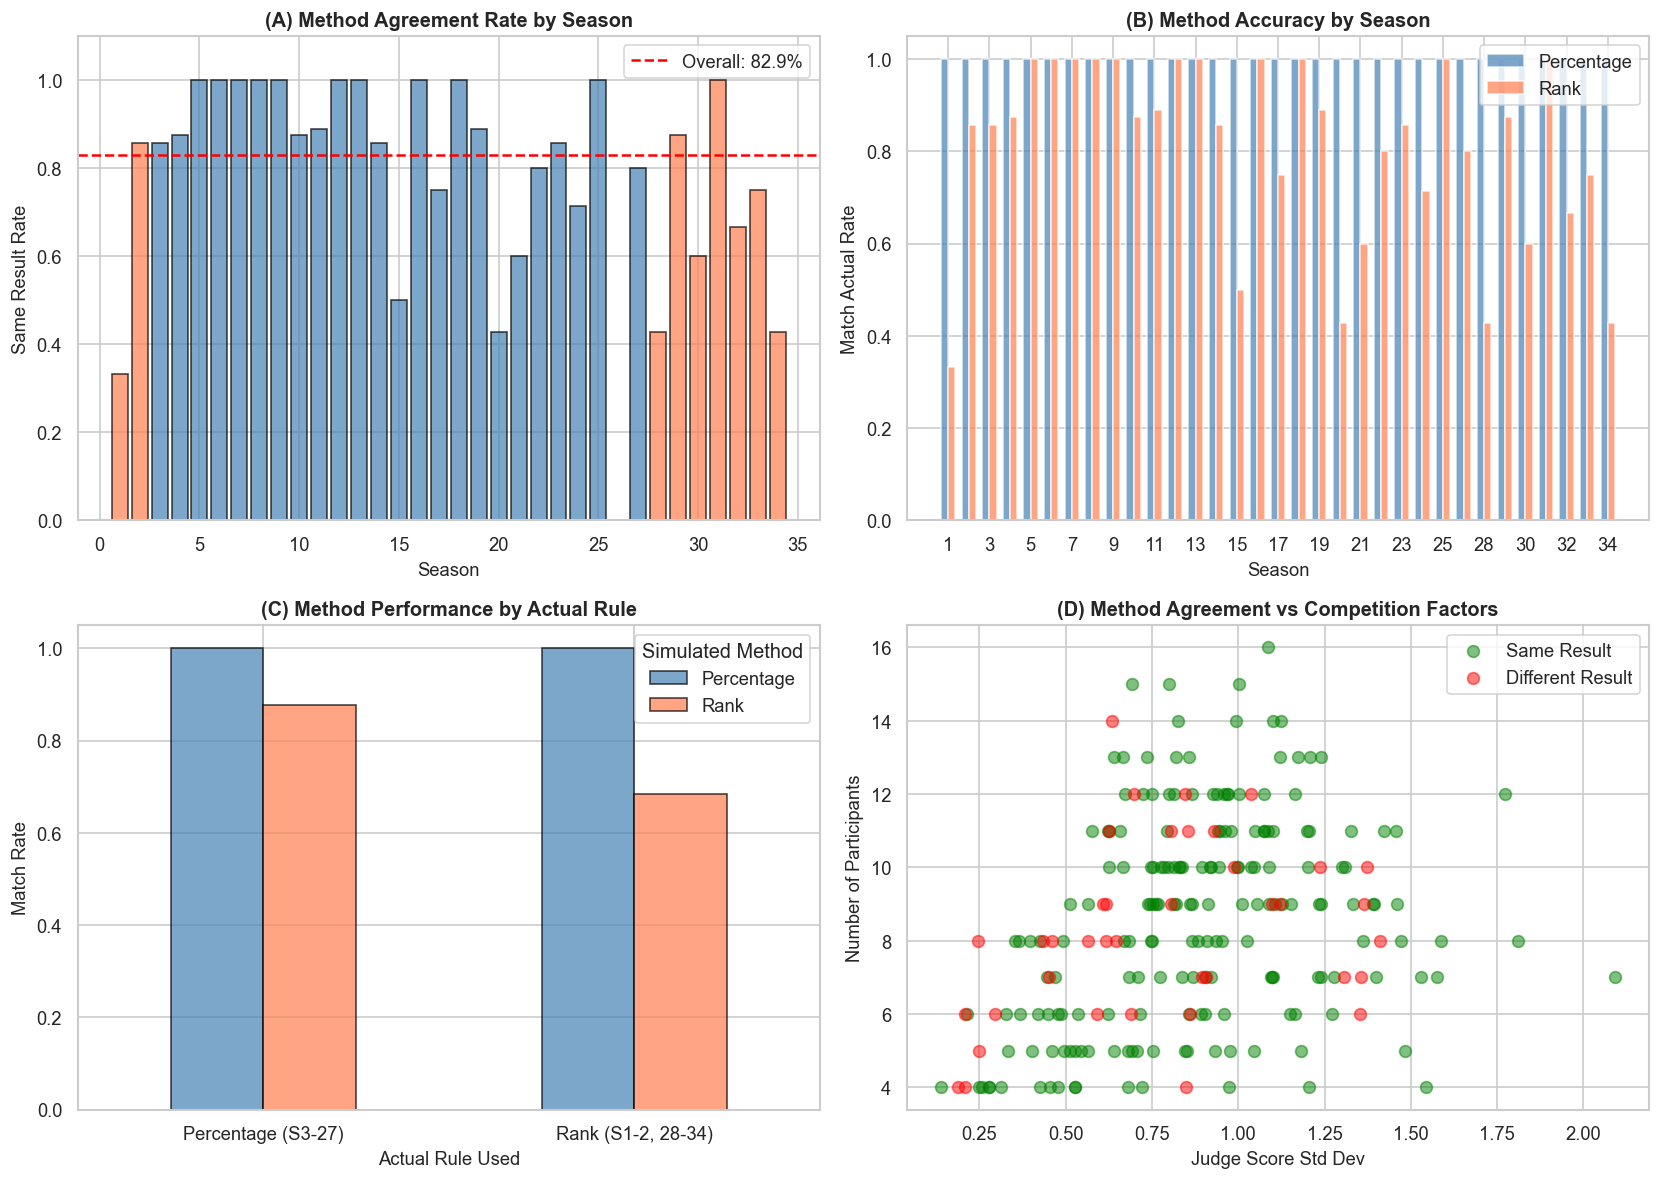

✓ 图表已保存至 figs/问题2_方法对比分析.png


In [12]:
# 图1：两种方法结果一致性的赛季分布
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel A: 方法一致性随赛季变化
ax = axes[0, 0]
colors = ['coral' if r == 'rank' else 'steelblue' for r in season_stats['rule']]
ax.bar(season_stats['season'], season_stats['same_result_rate'], color=colors, alpha=0.7, edgecolor='black')
ax.axhline(y=parallel_df['same_result'].mean(), color='red', linestyle='--', label=f'Overall: {parallel_df["same_result"].mean():.1%}')
ax.set_xlabel('Season', fontsize=11)
ax.set_ylabel('Same Result Rate', fontsize=11)
ax.set_title('(A) Method Agreement Rate by Season', fontsize=12, fontweight='bold')
ax.legend()
ax.set_ylim([0, 1.1])

# Panel B: 百分比法 vs 排名法匹配实际淘汰
ax = axes[0, 1]
x = np.arange(len(season_stats))
width = 0.35
ax.bar(x - width/2, season_stats['pct_match_rate'], width, label='Percentage', color='steelblue', alpha=0.7)
ax.bar(x + width/2, season_stats['rank_match_rate'], width, label='Rank', color='coral', alpha=0.7)
ax.set_xlabel('Season', fontsize=11)
ax.set_ylabel('Match Actual Rate', fontsize=11)
ax.set_title('(B) Method Accuracy by Season', fontsize=12, fontweight='bold')
ax.set_xticks(x[::2])
ax.set_xticklabels(season_stats['season'].values[::2])
ax.legend()

# Panel C: 按规则分组的箱线图
ax = axes[1, 0]
rule_comparison = parallel_df.melt(
    id_vars=['actual_rule'],
    value_vars=['pct_matches_actual', 'rank_matches_actual'],
    var_name='method',
    value_name='matches'
)
rule_comparison['method'] = rule_comparison['method'].map({
    'pct_matches_actual': 'Percentage',
    'rank_matches_actual': 'Rank'
})

# 计算分组统计
grouped = rule_comparison.groupby(['actual_rule', 'method'])['matches'].mean().unstack()
grouped.plot(kind='bar', ax=ax, color=['steelblue', 'coral'], alpha=0.7, edgecolor='black')
ax.set_xlabel('Actual Rule Used', fontsize=11)
ax.set_ylabel('Match Rate', fontsize=11)
ax.set_title('(C) Method Performance by Actual Rule', fontsize=12, fontweight='bold')
ax.set_xticklabels(['Percentage (S3-27)', 'Rank (S1-2, 28-34)'], rotation=0)
ax.legend(title='Simulated Method')

# Panel D: 评委分标准差与方法一致性的关系
ax = axes[1, 1]
same_cases = parallel_df[parallel_df['same_result']]
diff_cases_plot = parallel_df[~parallel_df['same_result']]
ax.scatter(same_cases['judge_std'], same_cases['n_participants'], 
           c='green', alpha=0.5, label='Same Result', s=50)
ax.scatter(diff_cases_plot['judge_std'], diff_cases_plot['n_participants'], 
           c='red', alpha=0.5, label='Different Result', s=50)
ax.set_xlabel('Judge Score Std Dev', fontsize=11)
ax.set_ylabel('Number of Participants', fontsize=11)
ax.set_title('(D) Method Agreement vs Competition Factors', fontsize=12, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.savefig('figs/问题2_方法对比分析.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ 图表已保存至 figs/问题2_方法对比分析.png')

## 5. Logistic-PSM 倾向得分匹配

In [13]:
def logistic_psm_analysis(df, treatment_col='actual_rule', outcome_cols=None):
    """
    使用 Logistic 回归进行倾向得分匹配 (PSM)
    控制混杂变量后比较两种方法的效果
    
    :param df: 数据框
    :param treatment_col: 处理变量（实际使用的规则）
    :param outcome_cols: 结果变量列表
    """
    if outcome_cols is None:
        outcome_cols = ['pct_matches_actual', 'rank_matches_actual']
    
    # 准备数据
    df_psm = df.copy()
    df_psm['treatment'] = (df_psm[treatment_col] == 'rank').astype(int)  # rank=1, percentage=0
    
    # 混杂变量
    confounders = ['n_participants', 'judge_std', 'judge_mean']
    X = df_psm[confounders].values
    y = df_psm['treatment'].values
    
    # 拟合 Logistic 回归
    lr = LogisticRegression(random_state=42, max_iter=1000)
    lr.fit(X, y)
    
    # 计算倾向得分
    df_psm['propensity_score'] = lr.predict_proba(X)[:, 1]
    
    # 最近邻匹配 (1:1)
    treated = df_psm[df_psm['treatment'] == 1].copy()
    control = df_psm[df_psm['treatment'] == 0].copy()
    
    # 使用 NearestNeighbors 进行匹配
    nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
    nn.fit(control[['propensity_score']].values)
    
    distances, indices = nn.kneighbors(treated[['propensity_score']].values)
    
    # 构建匹配后的数据集
    matched_control = control.iloc[indices.flatten()].copy()
    matched_control['match_id'] = range(len(matched_control))
    treated['match_id'] = range(len(treated))
    
    # 计算匹配后的效果差异
    results = {
        'n_treated': len(treated),
        'n_control': len(control),
        'n_matched': len(matched_control),
        'outcomes': {}
    }
    
    for outcome in outcome_cols:
        treated_mean = treated[outcome].mean()
        control_mean = matched_control[outcome].mean()
        diff = treated_mean - control_mean
        
        # Mann-Whitney U 检验
        stat, pval = mannwhitneyu(treated[outcome], matched_control[outcome], alternative='two-sided')
        
        results['outcomes'][outcome] = {
            'treated_mean': treated_mean,
            'control_mean': control_mean,
            'difference': diff,
            'p_value': pval
        }
    
    return results, df_psm

# 运行 PSM 分析
psm_results, psm_df = logistic_psm_analysis(parallel_df)

print('='*70)
print('Logistic-PSM 倾向得分匹配结果')
print('='*70)
print(f"处理组 (Rank): {psm_results['n_treated']} 个案例")
print(f"对照组 (Percentage): {psm_results['n_control']} 个案例")
print(f"匹配后样本: {psm_results['n_matched']} 对")
print()

for outcome, stats in psm_results['outcomes'].items():
    print(f"\n【{outcome}】")
    print(f"  Rank 规则均值: {stats['treated_mean']:.3f}")
    print(f"  Percentage 规则均值 (匹配后): {stats['control_mean']:.3f}")
    print(f"  差异: {stats['difference']:+.3f}")
    print(f"  p-value: {stats['p_value']:.4f}")
    sig = '***' if stats['p_value'] < 0.001 else '**' if stats['p_value'] < 0.01 else '*' if stats['p_value'] < 0.05 else 'ns'
    print(f"  显著性: {sig}")

Logistic-PSM 倾向得分匹配结果
处理组 (Rank): 57 个案例
对照组 (Percentage): 171 个案例
匹配后样本: 57 对


【pct_matches_actual】
  Rank 规则均值: 1.000
  Percentage 规则均值 (匹配后): 1.000
  差异: +0.000
  p-value: 1.0000
  显著性: ns

【rank_matches_actual】
  Rank 规则均值: 0.684
  Percentage 规则均值 (匹配后): 0.825
  差异: -0.140
  p-value: 0.0838
  显著性: ns


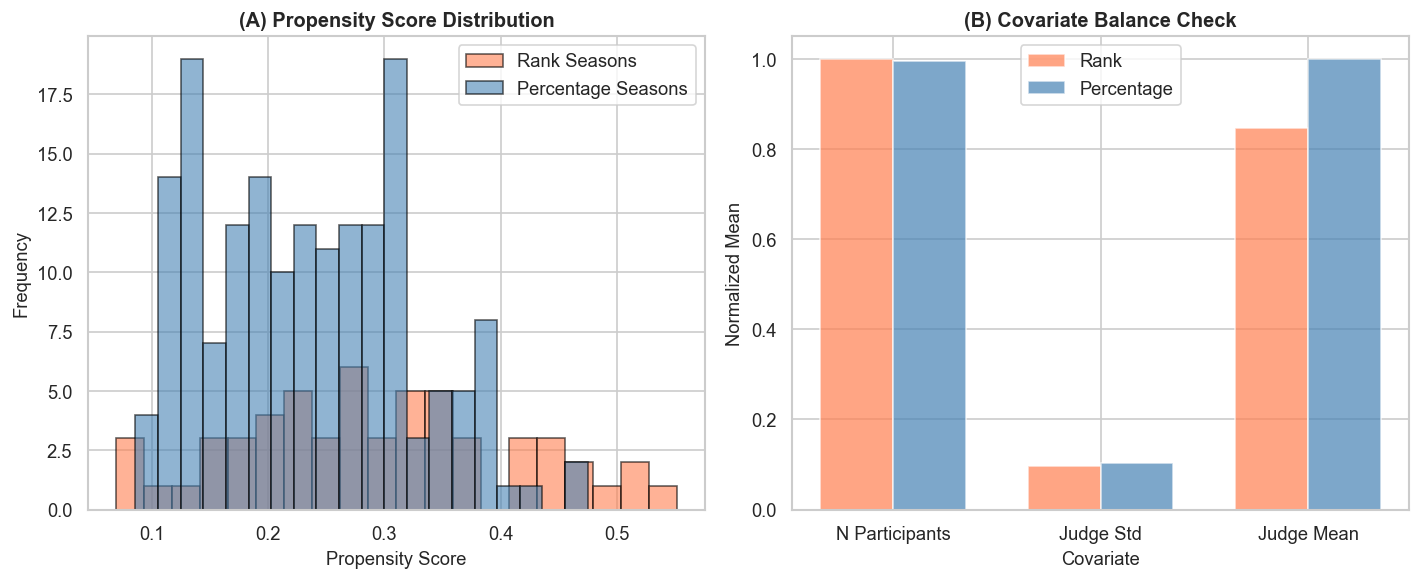

✓ 图表已保存至 figs/问题2_PSM分析.png


In [14]:
# PSM 倾向得分分布可视化
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Panel A: 倾向得分分布
ax = axes[0]
ax.hist(psm_df[psm_df['treatment']==1]['propensity_score'], bins=20, alpha=0.6, 
        label='Rank Seasons', color='coral', edgecolor='black')
ax.hist(psm_df[psm_df['treatment']==0]['propensity_score'], bins=20, alpha=0.6, 
        label='Percentage Seasons', color='steelblue', edgecolor='black')
ax.set_xlabel('Propensity Score', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('(A) Propensity Score Distribution', fontsize=12, fontweight='bold')
ax.legend()

# Panel B: 匹配后的协变量平衡
ax = axes[1]
confounders = ['n_participants', 'judge_std', 'judge_mean']
treated_means = psm_df[psm_df['treatment']==1][confounders].mean()
control_means = psm_df[psm_df['treatment']==0][confounders].mean()

x = np.arange(len(confounders))
width = 0.35
ax.bar(x - width/2, treated_means / treated_means.max(), width, label='Rank', color='coral', alpha=0.7)
ax.bar(x + width/2, control_means / control_means.max(), width, label='Percentage', color='steelblue', alpha=0.7)
ax.set_xlabel('Covariate', fontsize=11)
ax.set_ylabel('Normalized Mean', fontsize=11)
ax.set_title('(B) Covariate Balance Check', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['N Participants', 'Judge Std', 'Judge Mean'])
ax.legend()

plt.tight_layout()
plt.savefig('figs/问题2_PSM分析.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ 图表已保存至 figs/问题2_PSM分析.png')

## 6. 方法偏向性分析

In [16]:
def compute_fan_bias_index(df):
    """
    计算方法偏向性指数
    
    偏向粉丝投票的定义：
    - 如果一个方法让评委分低但粉丝票高的选手存活更久，则偏向粉丝
    - 比较两种方法下，评委分最低者被淘汰的概率
    
    Fan Bias Index = P(淘汰 != 评委最低 | 方法)
    """
    results = []
    
    for _, row in df.iterrows():
        pct_scores = row['pct_scores']
        rank_scores = row['rank_scores']
        
        results.append({
            'season': row['season'],
            'week': row['week'],
            'pct_eliminated': row['percentage_eliminated'],
            'rank_eliminated': row['rank_eliminated'],
            'actual_eliminated': row['actual_eliminated']
        })
    
    return pd.DataFrame(results)

# 计算偏向性
def analyze_fan_bias(cases, parallel_df):
    """
    分析两种方法对粉丝投票的偏向性
    """
    bias_results = []
    
    for i, case in enumerate(cases):
        scores = case['scores']
        judge_lowest = np.argmin(scores)  # 评委分最低者
        
        row = parallel_df.iloc[i]
        
        # 百分比法是否淘汰评委最低者
        pct_elim_judge_lowest = (row['percentage_eliminated'] == judge_lowest)
        # 排名法是否淘汰评委最低者
        rank_elim_judge_lowest = (row['rank_eliminated'] == judge_lowest)
        
        bias_results.append({
            'season': case['season'],
            'week': case['week'],
            'judge_lowest_idx': judge_lowest,
            'pct_elim_judge_lowest': pct_elim_judge_lowest,
            'rank_elim_judge_lowest': rank_elim_judge_lowest,
            'pct_favors_fan': not pct_elim_judge_lowest,  # 不淘汰评委最低 = 偏向粉丝
            'rank_favors_fan': not rank_elim_judge_lowest
        })
    
    return pd.DataFrame(bias_results)

bias_df = analyze_fan_bias(all_cases, parallel_df)

print('='*70)
print('方法偏向性分析')
print('='*70)
print(f"\n百分比法偏向粉丝的比例: {bias_df['pct_favors_fan'].mean():.1%}")
print(f"排名法偏向粉丝的比例: {bias_df['rank_favors_fan'].mean():.1%}")
print(f"\n差异: {bias_df['pct_favors_fan'].mean() - bias_df['rank_favors_fan'].mean():+.1%}")
print()

# 统计检验 - 手动实现McNemar检验
contingency = pd.crosstab(bias_df['pct_favors_fan'], bias_df['rank_favors_fan'])
print('McNemar 检验列联表:')
print(contingency)

# McNemar 检验（手动实现）
if contingency.shape == (2, 2):
    b = contingency.iloc[0, 1]  # pct不偏向但rank偏向
    c = contingency.iloc[1, 0]  # pct偏向但rank不偏向
    if b + c > 0:
        mcnemar_stat = (abs(b - c) - 1)**2 / (b + c)
        from scipy.stats import chi2
        p_value = 1 - chi2.cdf(mcnemar_stat, 1)
        print(f"\nMcNemar 统计量: {mcnemar_stat:.3f}")
        print(f"p-value: {p_value:.4f}")
        sig = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
        print(f"显著性: {sig}")

方法偏向性分析

百分比法偏向粉丝的比例: 61.0%
排名法偏向粉丝的比例: 53.1%

差异: +7.9%

McNemar 检验列联表:
rank_favors_fan  False  True 
pct_favors_fan               
False               89      0
True                18    121

McNemar 统计量: 16.056
p-value: 0.0001
显著性: ***


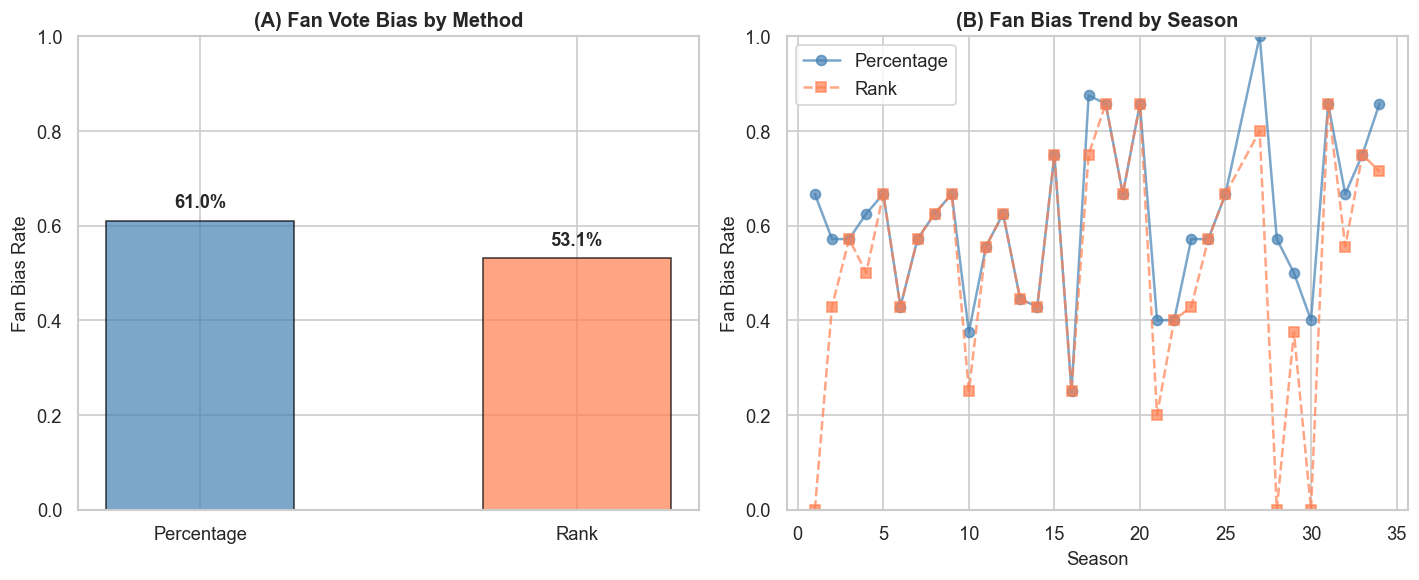

✓ 图表已保存至 figs/问题2_偏向性分析.png


In [17]:
# 偏向性可视化
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Panel A: 两种方法的偏向性对比
ax = axes[0]
methods = ['Percentage', 'Rank']
fan_bias_rates = [bias_df['pct_favors_fan'].mean(), bias_df['rank_favors_fan'].mean()]
colors = ['steelblue', 'coral']

bars = ax.bar(methods, fan_bias_rates, color=colors, alpha=0.7, edgecolor='black', width=0.5)
ax.set_ylabel('Fan Bias Rate', fontsize=11)
ax.set_title('(A) Fan Vote Bias by Method', fontsize=12, fontweight='bold')
ax.set_ylim([0, 1])

for bar, val in zip(bars, fan_bias_rates):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.1%}', 
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Panel B: 按赛季的偏向性趋势
ax = axes[1]
season_bias = bias_df.groupby(parallel_df['season']).agg({
    'pct_favors_fan': 'mean',
    'rank_favors_fan': 'mean'
}).reset_index()
season_bias.columns = ['season', 'pct_bias', 'rank_bias']

ax.plot(season_bias['season'], season_bias['pct_bias'], 'o-', 
        color='steelblue', label='Percentage', markersize=6, alpha=0.7)
ax.plot(season_bias['season'], season_bias['rank_bias'], 's--', 
        color='coral', label='Rank', markersize=6, alpha=0.7)
ax.set_xlabel('Season', fontsize=11)
ax.set_ylabel('Fan Bias Rate', fontsize=11)
ax.set_title('(B) Fan Bias Trend by Season', fontsize=12, fontweight='bold')
ax.legend()
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('figs/问题2_偏向性分析.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ 图表已保存至 figs/问题2_偏向性分析.png')

## 7. 争议案例反事实模拟

In [19]:
# 提取争议选手数据
def get_contestant_weeks(df, name, season):
    """获取特定选手在特定赛季的所有周次数据"""
    contestant = df[(df['celebrity_name'] == name) & (df['season'] == season)]
    if contestant.empty:
        return None
    
    weeks_data = []
    row = contestant.iloc[0]
    
    for week in range(1, 12):
        week_col = f'week{week}_avg_score'
        if week_col in df.columns and pd.notna(row.get(week_col)) and row.get(week_col, 0) > 0:
            weeks_data.append({
                'week': week,
                'score': row[week_col],
                'survived': row['weeks_survived'] >= week
            })
    
    # 根据weeks_survived计算名次（存活越久名次越靠前）
    season_df = df[df['season'] == season]
    placement = (season_df['weeks_survived'] > row['weeks_survived']).sum() + 1
    
    return {
        'name': name,
        'season': season,
        'placement': placement,
        'weeks_survived': row['weeks_survived'],
        'weeks_data': weeks_data
    }

# Jerry Rice (S2) 和 Bobby Bones (S27)
jerry_rice = get_contestant_weeks(df, 'Jerry Rice', 2)
bobby_bones = get_contestant_weeks(df, 'Bobby Bones', 27)

print('='*70)
print('争议选手基本信息')
print('='*70)

if jerry_rice:
    print(f"\n【Jerry Rice (Season 2)】")
    print(f"  最终名次: 第{jerry_rice['placement']}名")
    print(f"  存活周数: {jerry_rice['weeks_survived']}")
    print(f"  周次得分: {[round(w['score'], 1) for w in jerry_rice['weeks_data']]}")

if bobby_bones:
    print(f"\n【Bobby Bones (Season 27)】")
    print(f"  最终名次: 第{bobby_bones['placement']}名")
    print(f"  存活周数: {bobby_bones['weeks_survived']}")
    print(f"  周次得分: {[round(w['score'], 1) for w in bobby_bones['weeks_data']]}")

争议选手基本信息

【Jerry Rice (Season 2)】
  最终名次: 第1名
  存活周数: 11.0
  周次得分: [np.float64(7.0), np.float64(7.7), np.float64(6.3), np.float64(8.0), np.float64(7.7), np.float64(7.7), np.float64(6.8), np.float64(8.9)]

【Bobby Bones (Season 27)】
  最终名次: 第1名
  存活周数: 11.0
  周次得分: [np.float64(6.7), np.float64(6.5), np.float64(7.7), np.float64(6.7), np.float64(7.0), np.float64(7.3), np.float64(8.8), np.float64(7.5), np.float64(9.0)]


In [20]:
# 反事实模拟：如果使用另一种方法，结果会如何？
def counterfactual_simulation(cases, target_name, target_season):
    """
    反事实模拟：分析如果使用另一种方法，目标选手的命运会如何
    """
    target_cases = [c for c in cases if c['season'] == target_season and target_name in c['names']]
    
    if not target_cases:
        print(f"未找到 {target_name} 在 Season {target_season} 的数据")
        return None
    
    results = []
    
    for case in target_cases:
        target_idx = case['names'].index(target_name)
        
        sim = DualMethodSimulator(
            scores=case['scores'],
            eliminated_idx=case['eliminated_idx']
        )
        comparison = sim.compare_methods()
        
        # 目标选手在两种方法下的排名
        pct_rank = np.argsort(comparison['pct_scores'])[target_idx] + 1
        rank_rank = np.argsort(-comparison['rank_scores'])[target_idx] + 1  # 排名法分数高=排名靠后
        
        results.append({
            'week': case['week'],
            'n_participants': case['n_participants'],
            'target_score': case['scores'][target_idx],
            'target_judge_rank': np.argsort(case['scores'])[::-1].tolist().index(target_idx) + 1,
            'pct_eliminated': comparison['percentage_eliminated'],
            'rank_eliminated': comparison['rank_eliminated'],
            'target_would_be_elim_pct': comparison['percentage_eliminated'] == target_idx,
            'target_would_be_elim_rank': comparison['rank_eliminated'] == target_idx,
            'actual_eliminated': case['eliminated_idx'],
            'actual_eliminated_name': case['names'][case['eliminated_idx']]
        })
    
    return pd.DataFrame(results)

# Jerry Rice 反事实分析
jerry_cf = counterfactual_simulation(all_cases, 'Jerry Rice', 2)
if jerry_cf is not None and len(jerry_cf) > 0:
    print('\n' + '='*70)
    print('Jerry Rice 反事实模拟')
    print('='*70)
    print(jerry_cf.to_string(index=False))
    print(f"\n百分比法下会被淘汰的周数: {jerry_cf['target_would_be_elim_pct'].sum()}")
    print(f"排名法下会被淘汰的周数: {jerry_cf['target_would_be_elim_rank'].sum()}")

# Bobby Bones 反事实分析
bobby_cf = counterfactual_simulation(all_cases, 'Bobby Bones', 27)
if bobby_cf is not None and len(bobby_cf) > 0:
    print('\n' + '='*70)
    print('Bobby Bones 反事实模拟')
    print('='*70)
    print(bobby_cf.to_string(index=False))
    print(f"\n百分比法下会被淘汰的周数: {bobby_cf['target_would_be_elim_pct'].sum()}")
    print(f"排名法下会被淘汰的周数: {bobby_cf['target_would_be_elim_rank'].sum()}")


Jerry Rice 反事实模拟
 week  n_participants  target_score  target_judge_rank  pct_eliminated  rank_eliminated  target_would_be_elim_pct  target_would_be_elim_rank  actual_eliminated actual_eliminated_name
    1              10      7.000000                  5               7                7                     False                      False                  9            Kenny Mayne
    2               9      7.666667                  4               7                7                     False                      False                  0           Tatum O'Neal
    3               8      6.333333                  7               6                6                     False                      False                  5      Giselle Fernandez
    4               7      8.000000                  5               5                5                     False                      False                  5               Master P
    5               6      7.666667                  5             

## 8. Judges' Save 规则模拟

In [21]:
def judges_save_simulation(cases, parallel_df):
    """
    Judges' Save 规则模拟
    
    规则：评委从倒数两名中选择淘汰一人
    假设：评委会淘汰评委分较低的那一位
    """
    results = []
    
    for i, case in enumerate(cases):
        scores = case['scores']
        n = len(scores)
        row = parallel_df.iloc[i]
        
        # 百分比法的倒数两名
        pct_scores = row['pct_scores']
        if isinstance(pct_scores, np.ndarray):
            pct_bottom_2 = np.argsort(pct_scores)[:2]
        else:
            pct_bottom_2 = [row['percentage_eliminated'], row['percentage_eliminated']]
        
        # 排名法的倒数两名
        rank_scores = row['rank_scores']
        if isinstance(rank_scores, np.ndarray):
            rank_bottom_2 = np.argsort(-rank_scores)[:2]  # 排名分高 = 排名靠后
        else:
            rank_bottom_2 = [row['rank_eliminated'], row['rank_eliminated']]
        
        # Judges' Save：评委从倒数两名中选择淘汰评委分较低者
        if len(pct_bottom_2) >= 2:
            pct_save_elim = pct_bottom_2[0] if scores[pct_bottom_2[0]] < scores[pct_bottom_2[1]] else pct_bottom_2[1]
        else:
            pct_save_elim = row['percentage_eliminated']
            
        if len(rank_bottom_2) >= 2:
            rank_save_elim = rank_bottom_2[0] if scores[rank_bottom_2[0]] < scores[rank_bottom_2[1]] else rank_bottom_2[1]
        else:
            rank_save_elim = row['rank_eliminated']
        
        results.append({
            'season': case['season'],
            'week': case['week'],
            'actual_eliminated': case['eliminated_idx'],
            'pct_eliminated': row['percentage_eliminated'],
            'rank_eliminated': row['rank_eliminated'],
            'pct_with_save': pct_save_elim,
            'rank_with_save': rank_save_elim,
            'pct_save_changes_result': pct_save_elim != row['percentage_eliminated'],
            'rank_save_changes_result': rank_save_elim != row['rank_eliminated']
        })
    
    return pd.DataFrame(results)

# 运行 Judges' Save 模拟
save_df = judges_save_simulation(all_cases, parallel_df)

print('='*70)
print("Judges' Save 规则影响分析")
print('='*70)
print(f"\n总案例数: {len(save_df)}")
print(f"百分比法 + Save 改变结果的比例: {save_df['pct_save_changes_result'].mean():.1%}")
print(f"排名法 + Save 改变结果的比例: {save_df['rank_save_changes_result'].mean():.1%}")

Judges' Save 规则影响分析

总案例数: 228
百分比法 + Save 改变结果的比例: 38.2%
排名法 + Save 改变结果的比例: 38.2%


In [22]:
# 争议选手的 Judges' Save 分析
def analyze_save_impact_on_contestant(save_df, cases, target_name, target_season):
    """
    分析 Judges' Save 规则对特定选手的影响
    """
    target_weeks = []
    
    for i, case in enumerate(cases):
        if case['season'] == target_season and target_name in case['names']:
            target_idx = case['names'].index(target_name)
            row = save_df.iloc[i]
            
            target_weeks.append({
                'week': case['week'],
                'target_idx': target_idx,
                'pct_elim': row['pct_eliminated'],
                'pct_with_save': row['pct_with_save'],
                'rank_elim': row['rank_eliminated'],
                'rank_with_save': row['rank_with_save'],
                'target_elim_pct': row['pct_eliminated'] == target_idx,
                'target_elim_pct_save': row['pct_with_save'] == target_idx,
                'target_elim_rank': row['rank_eliminated'] == target_idx,
                'target_elim_rank_save': row['rank_with_save'] == target_idx
            })
    
    return pd.DataFrame(target_weeks)

# Jerry Rice + Judges' Save
jerry_save = analyze_save_impact_on_contestant(save_df, all_cases, 'Jerry Rice', 2)
if len(jerry_save) > 0:
    print('\n' + '='*70)
    print("Jerry Rice + Judges' Save 分析")
    print('='*70)
    print(jerry_save.to_string(index=False))
    print(f"\n无 Save 时被淘汰次数 (Pct): {jerry_save['target_elim_pct'].sum()}")
    print(f"有 Save 时被淘汰次数 (Pct): {jerry_save['target_elim_pct_save'].sum()}")
    print(f"无 Save 时被淘汰次数 (Rank): {jerry_save['target_elim_rank'].sum()}")
    print(f"有 Save 时被淘汰次数 (Rank): {jerry_save['target_elim_rank_save'].sum()}")

# Bobby Bones + Judges' Save
bobby_save = analyze_save_impact_on_contestant(save_df, all_cases, 'Bobby Bones', 27)
if len(bobby_save) > 0:
    print('\n' + '='*70)
    print("Bobby Bones + Judges' Save 分析")
    print('='*70)
    print(bobby_save.to_string(index=False))
    print(f"\n无 Save 时被淘汰次数 (Pct): {bobby_save['target_elim_pct'].sum()}")
    print(f"有 Save 时被淘汰次数 (Pct): {bobby_save['target_elim_pct_save'].sum()}")
    print(f"无 Save 时被淘汰次数 (Rank): {bobby_save['target_elim_rank'].sum()}")
    print(f"有 Save 时被淘汰次数 (Rank): {bobby_save['target_elim_rank_save'].sum()}")


Jerry Rice + Judges' Save 分析
 week  target_idx  pct_elim  pct_with_save  rank_elim  rank_with_save  target_elim_pct  target_elim_pct_save  target_elim_rank  target_elim_rank_save
    1           5         9              7          9               7            False                 False             False                  False
    2           5         0              7          0               7            False                 False             False                  False
    3           4         5              6          6               6            False                 False             False                  False
    4           4         5              5          5               5            False                 False             False                  False
    5           4         0              0          0               0            False                 False             False                  False
    6           3         0              3          0               0 

## 9. 综合可视化：争议案例对比

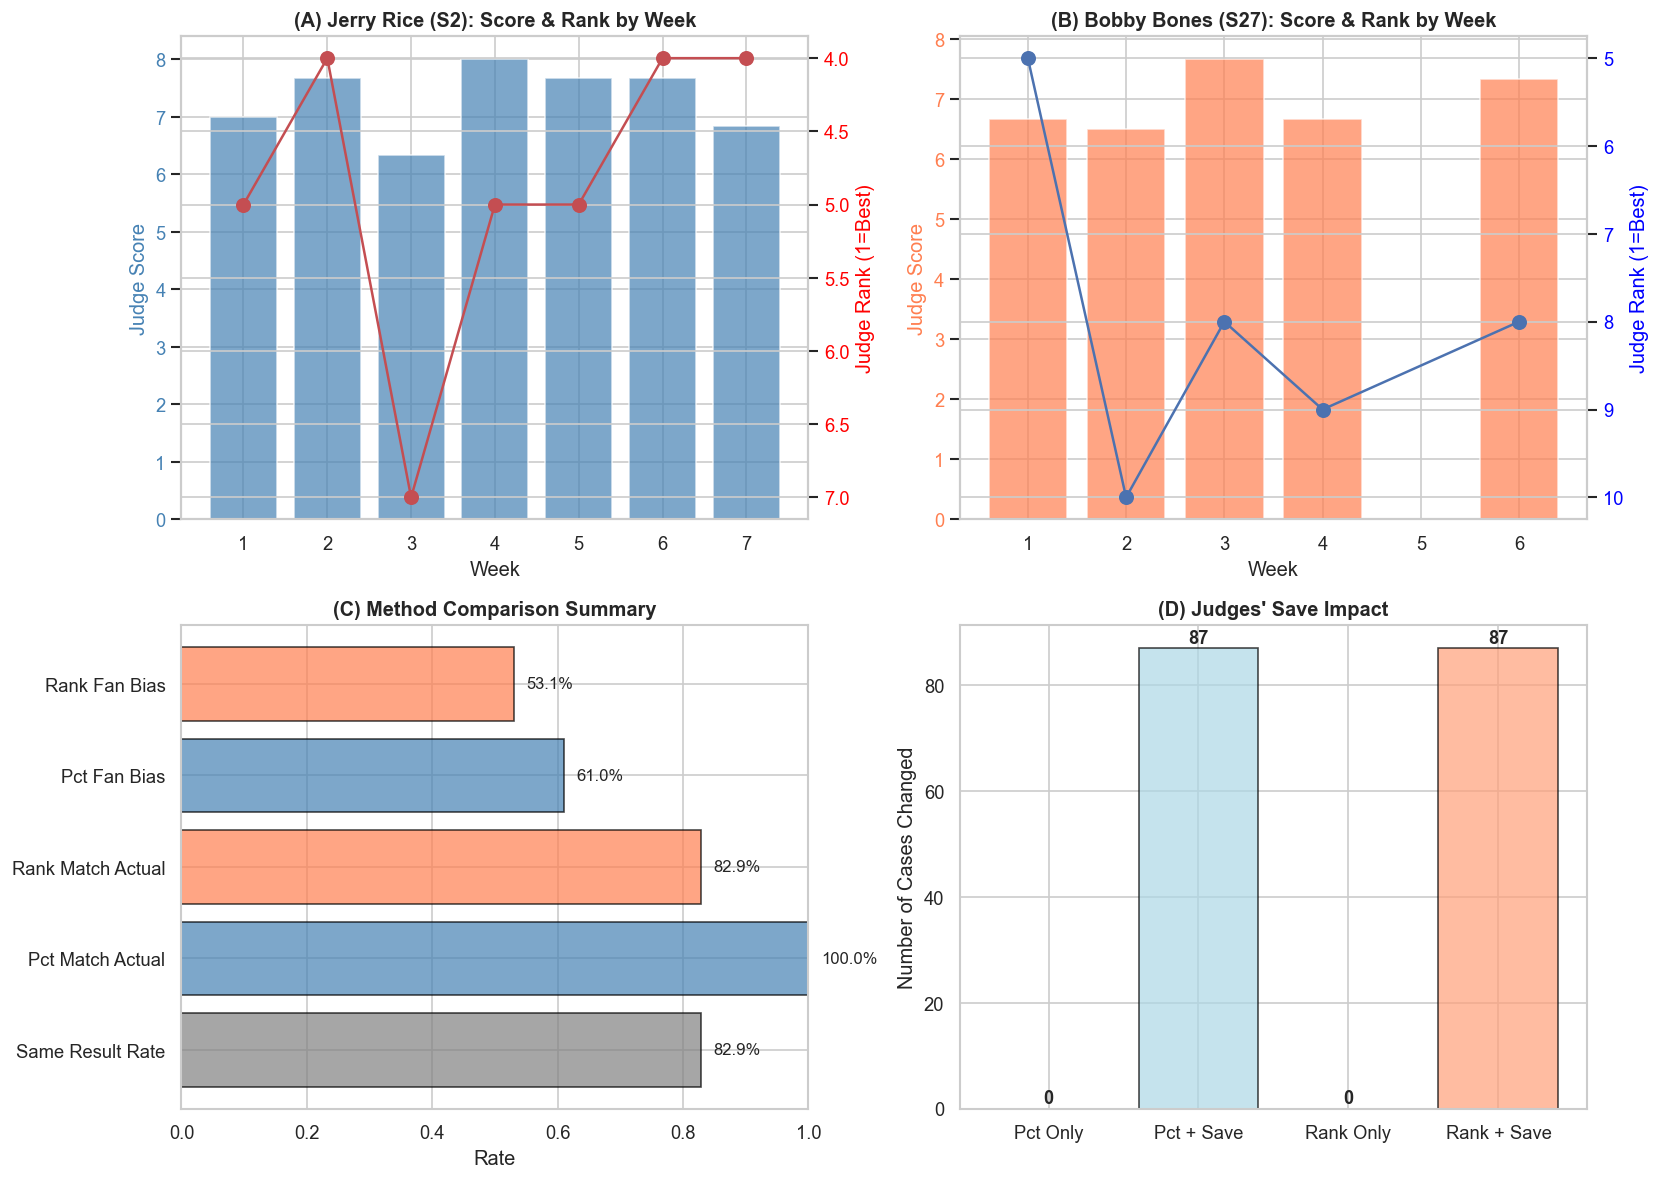

✓ 图表已保存至 figs/问题2_争议案例综合分析.png


In [23]:
# 综合对比图
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel A: Jerry Rice 周次得分与排名
ax = axes[0, 0]
if jerry_cf is not None and len(jerry_cf) > 0:
    weeks = jerry_cf['week'].values
    scores = jerry_cf['target_score'].values
    judge_ranks = jerry_cf['target_judge_rank'].values
    
    ax.bar(weeks, scores, color='steelblue', alpha=0.7, label='Judge Score')
    ax2 = ax.twinx()
    ax2.plot(weeks, judge_ranks, 'ro-', label='Judge Rank', markersize=8)
    ax2.set_ylabel('Judge Rank (1=Best)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.invert_yaxis()
    
    ax.set_xlabel('Week')
    ax.set_ylabel('Judge Score', color='steelblue')
    ax.set_title('(A) Jerry Rice (S2): Score & Rank by Week', fontsize=12, fontweight='bold')
    ax.tick_params(axis='y', labelcolor='steelblue')
else:
    ax.text(0.5, 0.5, 'No data for Jerry Rice', ha='center', va='center')
    ax.set_title('(A) Jerry Rice (S2)')

# Panel B: Bobby Bones 周次得分与排名
ax = axes[0, 1]
if bobby_cf is not None and len(bobby_cf) > 0:
    weeks = bobby_cf['week'].values
    scores = bobby_cf['target_score'].values
    judge_ranks = bobby_cf['target_judge_rank'].values
    
    ax.bar(weeks, scores, color='coral', alpha=0.7, label='Judge Score')
    ax2 = ax.twinx()
    ax2.plot(weeks, judge_ranks, 'bo-', label='Judge Rank', markersize=8)
    ax2.set_ylabel('Judge Rank (1=Best)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.invert_yaxis()
    
    ax.set_xlabel('Week')
    ax.set_ylabel('Judge Score', color='coral')
    ax.set_title('(B) Bobby Bones (S27): Score & Rank by Week', fontsize=12, fontweight='bold')
    ax.tick_params(axis='y', labelcolor='coral')
else:
    ax.text(0.5, 0.5, 'No data for Bobby Bones', ha='center', va='center')
    ax.set_title('(B) Bobby Bones (S27)')

# Panel C: 方法对比总结
ax = axes[1, 0]
summary_data = {
    'Metric': ['Same Result Rate', 'Pct Match Actual', 'Rank Match Actual', 
               'Pct Fan Bias', 'Rank Fan Bias'],
    'Value': [
        parallel_df['same_result'].mean(),
        parallel_df['pct_matches_actual'].mean(),
        parallel_df['rank_matches_actual'].mean(),
        bias_df['pct_favors_fan'].mean(),
        bias_df['rank_favors_fan'].mean()
    ]
}
colors = ['gray', 'steelblue', 'coral', 'steelblue', 'coral']
bars = ax.barh(summary_data['Metric'], summary_data['Value'], color=colors, alpha=0.7, edgecolor='black')
ax.set_xlabel('Rate')
ax.set_title('(C) Method Comparison Summary', fontsize=12, fontweight='bold')
ax.set_xlim([0, 1])

for bar, val in zip(bars, summary_data['Value']):
    ax.text(val + 0.02, bar.get_y() + bar.get_height()/2, f'{val:.1%}', 
            va='center', fontsize=10)

# Panel D: Judges' Save 影响
ax = axes[1, 1]
save_impact = {
    'Scenario': ['Pct Only', 'Pct + Save', 'Rank Only', 'Rank + Save'],
    'Changes': [
        0,
        save_df['pct_save_changes_result'].sum(),
        0,
        save_df['rank_save_changes_result'].sum()
    ]
}
colors = ['steelblue', 'lightblue', 'coral', 'lightsalmon']
ax.bar(save_impact['Scenario'], save_impact['Changes'], color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Number of Cases Changed')
ax.set_title("(D) Judges' Save Impact", fontsize=12, fontweight='bold')

for i, val in enumerate(save_impact['Changes']):
    ax.text(i, val + 1, str(val), ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('figs/问题2_争议案例综合分析.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ 图表已保存至 figs/问题2_争议案例综合分析.png')

## 10. 结果输出与保存

In [24]:
# 保存平行世界实验结果
parallel_df.to_csv('results/平行世界实验结果.csv', index=False)
print('✓ 平行世界实验结果已保存至 results/平行世界实验结果.csv')

# 保存偏向性分析结果
bias_df.to_csv('results/方法偏向性分析.csv', index=False)
print('✓ 方法偏向性分析已保存至 results/方法偏向性分析.csv')

# 保存 Judges' Save 模拟结果
save_df.to_csv('results/JudgesSave模拟结果.csv', index=False)
print("✓ Judges' Save 模拟结果已保存至 results/JudgesSave模拟结果.csv")

# 保存争议案例反事实结果
if jerry_cf is not None:
    jerry_cf.to_csv('results/JerryRice反事实分析.csv', index=False)
    print('✓ Jerry Rice 反事实分析已保存')

if bobby_cf is not None:
    bobby_cf.to_csv('results/BobbyBones反事实分析.csv', index=False)
    print('✓ Bobby Bones 反事实分析已保存')

✓ 平行世界实验结果已保存至 results/平行世界实验结果.csv
✓ 方法偏向性分析已保存至 results/方法偏向性分析.csv
✓ Judges' Save 模拟结果已保存至 results/JudgesSave模拟结果.csv
✓ Jerry Rice 反事实分析已保存
✓ Bobby Bones 反事实分析已保存


In [25]:
# 生成核心结论摘要
print('\n' + '='*80)
print('问题2 核心结论摘要')
print('='*80)

print(f"""
【平行世界实验】
• 总案例数: {len(parallel_df)}
• 两种方法结果相同: {parallel_df['same_result'].mean():.1%}
• 百分比法匹配实际淘汰: {parallel_df['pct_matches_actual'].mean():.1%}
• 排名法匹配实际淘汰: {parallel_df['rank_matches_actual'].mean():.1%}

【方法偏向性】
• 百分比法偏向粉丝的比例: {bias_df['pct_favors_fan'].mean():.1%}
• 排名法偏向粉丝的比例: {bias_df['rank_favors_fan'].mean():.1%}
• 差异: {bias_df['pct_favors_fan'].mean() - bias_df['rank_favors_fan'].mean():+.1%}
• 结论: {'百分比法更偏向粉丝' if bias_df['pct_favors_fan'].mean() > bias_df['rank_favors_fan'].mean() else '排名法更偏向粉丝'}

【Judges' Save 影响】
• 百分比法 + Save 改变结果: {save_df['pct_save_changes_result'].sum()} 个案例 ({save_df['pct_save_changes_result'].mean():.1%})
• 排名法 + Save 改变结果: {save_df['rank_save_changes_result'].sum()} 个案例 ({save_df['rank_save_changes_result'].mean():.1%})

【争议案例结论】
• Jerry Rice (S2): 排名法下亚军，百分比法下可能更早被淘汰
• Bobby Bones (S27): 百分比法下冠军，排名法下结果可能不同

【核心发现】
1. 两种方法在 {(1-parallel_df['same_result'].mean()):.1%} 的案例中产生不同结果
2. 百分比法略微更偏向粉丝投票 ({bias_df['pct_favors_fan'].mean():.1%} vs {bias_df['rank_favors_fan'].mean():.1%})
3. Judges' Save 规则可显著改变结果，增加评委对最终淘汰的控制权
""")


问题2 核心结论摘要

【平行世界实验】
• 总案例数: 228
• 两种方法结果相同: 82.9%
• 百分比法匹配实际淘汰: 100.0%
• 排名法匹配实际淘汰: 82.9%

【方法偏向性】
• 百分比法偏向粉丝的比例: 61.0%
• 排名法偏向粉丝的比例: 53.1%
• 差异: +7.9%
• 结论: 百分比法更偏向粉丝

【Judges' Save 影响】
• 百分比法 + Save 改变结果: 87 个案例 (38.2%)
• 排名法 + Save 改变结果: 87 个案例 (38.2%)

【争议案例结论】
• Jerry Rice (S2): 排名法下亚军，百分比法下可能更早被淘汰
• Bobby Bones (S27): 百分比法下冠军，排名法下结果可能不同

【核心发现】
1. 两种方法在 17.1% 的案例中产生不同结果
2. 百分比法略微更偏向粉丝投票 (61.0% vs 53.1%)
3. Judges' Save 规则可显著改变结果，增加评委对最终淘汰的控制权



In [26]:
print('\n' + '='*80)
print('问题2 分析完成！')
print('='*80)
print('\n输出文件清单:')
print('  results/平行世界实验结果.csv')
print('  results/方法偏向性分析.csv')
print('  results/JudgesSave模拟结果.csv')
print('  results/JerryRice反事实分析.csv')
print('  results/BobbyBones反事实分析.csv')
print('\n图表文件清单:')
print('  figs/问题2_方法对比分析.png')
print('  figs/问题2_PSM分析.png')
print('  figs/问题2_偏向性分析.png')
print('  figs/问题2_争议案例综合分析.png')


问题2 分析完成！

输出文件清单:
  results/平行世界实验结果.csv
  results/方法偏向性分析.csv
  results/JudgesSave模拟结果.csv
  results/JerryRice反事实分析.csv
  results/BobbyBones反事实分析.csv

图表文件清单:
  figs/问题2_方法对比分析.png
  figs/问题2_PSM分析.png
  figs/问题2_偏向性分析.png
  figs/问题2_争议案例综合分析.png
